# Generating tables and plots for the paper

The code in this notebook generates Tables 4 and 5, Figures 5 and 6 in our paper on [Provenance Graph Kernel](https://arxiv.org/abs/2010.10343). It is run automatically as part of the evaluation pipeline (`make plots`).

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")
sns.set_context("paper")

## Loading scoring and timing data

In [2]:
def load_scoring(dataset_id) -> pd.DataFrame:
    outputs_folder = Path("outputs") / dataset_id
    output_filepath = outputs_folder / "scoring.pickled"
    
    results = pd.read_pickle(output_filepath)
    
    return results

In [3]:
# Identifiers for the six datasets
dataset_ids = ["MIMIC-PXC7", "CM-Buildings", "CM-Routes", "CM-RouteSets", "PG-T", "PG-D"]
dataset_names = ["MIMIC", "CM-B", "CM-R", "CM-RS", "PG-T", "PG-D"]

In [4]:
# The following graph kernels are in the "slow" group
slow_GKs = {
    "GK-GSamp",
    "GK-NSPD",
    "GK-NH",
    "GK-SPath",
    "GK-WL-OA-1",
    "GK-WL-OA-2",
    "GK-WL-OA-3",
    "GK-WL-OA-4",
    "GK-WL-OA-5",
}

def name_group(method: str) -> str:
    if method in slow_GKs:
        return "GK-slow"
    elif method.startswith("GK-"):
        # all other graph kernels are in the "fast" group
        return "GK-fast"
    elif method.startswith("PNA-"):
        # Provenance Network Analytics method
        return "PNA"
    elif method.startswith("FG-"):
        # provenance kernels using generic PROV types
        return "PK-G"
    elif method.startswith("FA-"):
        # provenance kernels using generic PROV types and application types
        return "PK-A"
    else:
        return "AppData"

def best_performers(results: pd.DataFrame, scoring="accuracy"):
    # Give them a group name for plotting
    results = results.copy()
    # add a "group_name" column to the table
    results["group_name"] = results.method.map(name_group)

    best_methods = {
        # for each group, find the method that has the best mean scoring (default to accuracy)
        results[results.group_name == group_name].groupby("method")[scoring].mean().idxmax()
        for group_name in ["PK-G", "PK-A", "PNA", "GK-slow", "GK-fast"]
    }

    # return a filtered table with only the best methods identified above
    return results[results.method.isin(best_methods)]

### Loading scoring of the best methods

In [5]:
scorings = pd.DataFrame()

for dataset_id, dataset_name in zip(dataset_ids, dataset_names):
    # load the scoring data for this classification task
    df = load_scoring(dataset_id)
    df["dataset"] = dataset_name
    # only keep the scoring data of the best-performing methods in this task
    scorings = scorings.append(
        best_performers(df),
        ignore_index=True
    )

## Comparing timings of the best methods in each classification task

In [6]:
summary = scorings.groupby(["dataset", "group_name", "method"]).mean()
summary

accuracy        f1    recall  precision  \
dataset group_name method                                                
CM-B    GK-fast    GK-HC-2     0.893132  0.893132  0.893132   0.893132   
        GK-slow    GK-NSPD     0.903660  0.903660  0.903660   0.903660   
        PK-A       FA-1        0.895617  0.895617  0.895617   0.895617   
        PK-G       FG-2        0.896712  0.896712  0.896712   0.896712   
        PNA        PNA-RF      0.890938  0.890938  0.890938   0.890938   
CM-R    GK-fast    GK-WL-2     0.981218  0.981218  0.981218   0.981218   
        GK-slow    GK-WL-OA-4  0.974193  0.974193  0.974193   0.974193   
        PK-A       FA-3        0.969561  0.969561  0.969561   0.969561   
        PK-G       FG-4        0.921532  0.921532  0.921532   0.921532   
        PNA        PNA-DTree   0.937415  0.937415  0.937415   0.937415   
CM-RS   GK-fast    GK-WL-5     0.948198  0.948198  0.948198   0.948198   
        GK-slow    GK-WL-OA-5  0.962863  0.962863  0.962863   0.962863   
        PK-A       FA-2        0.966706  0.966706  0.966706   0.966706   
        PK-G       FG-5        0.961621  0.961621  0.961621   0.961621   
        PNA        PNA-DTree   0.942431  0.942431  0.942431   0.942431   
MIMIC   GK-fast    GK-WL-5     0.788423  0.788423  0.788423   0.788423   
        GK-slow    GK-GSamp    0.797887  0.797887  0.797887   0.797887   
        PK-A       FA-4        0.789931  0.789931  0.789931   0.789931   
        PK-G       FG-4        0.765112  0.765112  0.765112   0.765112   
        PNA        PNA-SVM     0.782534  0.782534  0.782534   0.782534   
PG-D    GK-fast    GK-WL-5     0.758583  0.758583  0.758583   0.758583   
        GK-slow    GK-SPath    0.772333  0.772333  0.772333   0.772333   
        PK-A       FA-2        0.782583  0.782583  0.782583   0.782583   
        PK-G       FG-5        0.753250  0.753250  0.753250   0.753250   
        PNA        PNA-SVM     0.712917  0.712917  0.712917   0.712917   
PG-T    GK-fast    GK-WL-5     0.704667  0.704667  0.704667   0.704667   
        GK-slow    GK-WL-OA-1  0.701333  0.701333  0.701333   0.701333   
        PK-A       FA-3        0.853250  0.853250  0.853250   0.853250   
        PK-G       FG-3        0.690500  0.690500  0.690500   0.690500   
        PNA        PNA-DTree   0.696833  0.696833  0.696833   0.696833   

                                      time  
dataset group_name method                   
CM-B    GK-fast    GK-HC-2        0.283388  
        GK-slow    GK-NSPD        6.637128  
        PK-A       FA-1           0.354425  
        PK-G       FG-2           0.397688  
        PNA        PNA-RF        56.649530  
CM-R    GK-fast    GK-WL-2        0.642961  
        GK-slow    GK-WL-OA-4    86.052596  
        PK-A       FA-3           1.137731  
        PK-G       FG-4           1.341518  
        PNA        PNA-DTree    175.302174  
CM-RS   GK-fast    GK-WL-5        2.636632  
        GK-slow    GK-WL-OA-5   271.458879  
        PK-A       FA-2           1.927001  
        PK-G       FG-5           2.630162  
        PNA        PNA-DTree    312.046381  
MIMIC   GK-fast    GK-WL-5        8.442996  
        GK-slow    GK-GSamp     446.138452  
        PK-A       FA-4           8.024474  
        PK-G       FG-4           6.678355  
        PNA        PNA-SVM     1808.749570  
PG-D    GK-fast    GK-WL-5        1.394120  
        GK-slow    GK-SPath      10.156886  
        PK-A       FA-2           1.848500  
        PK-G       FG-5           2.772211  
        PNA        PNA-SVM      392.974558  
PG-T    GK-fast    GK-WL-5        0.640198  
        GK-slow    GK-WL-OA-1    16.744692  
        PK-A       FA-3           0.835529  
        PK-G       FG-3           0.701627  
        PNA        PNA-DTree    100.881489

### Finding the time cost of the best PK method (between PK-G and PK-A)

In [7]:
best_pk_accuracy = dict()  # best accuracy between PK-G and PK-A for a classification task
best_pk_method = dict()  # achieved by which method
best_pk_time = dict()  # and its corresponding time cost

for row in summary.itertuples():
    dataset, group_name, method = row.Index

    if group_name in {"PK-G", "PK-A"}:
        to_be_updated = True
        try:
            if best_pk_accuracy[dataset] > row.accuracy:
                to_be_updated = False
        except KeyError:
            pass  # first time seeing this dataset, to reco

        if to_be_updated:
            best_pk_accuracy[dataset] = row.accuracy
            best_pk_method[dataset] = method
            best_pk_time[dataset] = row.time

### Calculating the relative time for all methods in each classification task

In [8]:
data = []

for row in summary.itertuples():
    dataset, group_name, method = row.Index
    relative_time = row.time / best_pk_time[dataset]
    data.append((dataset, group_name, method, row.accuracy, relative_time))

rel_time_df = pd.DataFrame(data, columns=["Dataset", "Group", "Method", "Accuracy", "Relative Time"])

In [9]:
# defining short names for methods to save space
method_short_names = {
    "FG-0": "G0",
    "FG-1": "G1",
    "FG-2": "G2",
    "FG-3": "G3",
    "FG-4": "G4",
    "FG-5": "G5",
    "FA-0": "A0",
    "FA-1": "A1",
    "FA-2": "A2",
    "FA-3": "A3",
    "FA-4": "A4",
    "FA-5": "A5",
    'PNA-DTree': "DT",
    'PNA-RF': "RF",
    'PNA-K-NB': "K-NB",
    'PNA-NBayes': "NB",
    'PNA-NN': "NN",
    'PNA-SVM': "SVM",
    'GK-SPath': "SP",
    'GK-EHist': "EH",
    'GK-VHist': "VH",
    'GK-GSamp': "GS",
    "GK-WL-1": "WL1",
    "GK-WL-2": "WL2",
    "GK-WL-3": "WL3",
    "GK-WL-4": "WL4",
    "GK-WL-5": "WL5",
    "GK-NH": "NH",
    "GK-HC-1": "HC1",
    "GK-HC-2": "HC2",
    "GK-HC-3": "HC3",
    "GK-HC-4": "HC4",
    "GK-HC-5": "HC5",
    "GK-NSPD": "NSPD",
    "GK-WL-OA-1": "WLO1",
    "GK-WL-OA-2": "WLO2",
    "GK-WL-OA-3": "WLO3",
    "GK-WL-OA-4": "WLO4",
    "GK-WL-OA-5": "WLO5",
}

### Table 4
Within each dataset, we report the time cost of the best-performing method (shown in parentheses) from each comparison group relative to the time taken by the best-performing PK method (whose time cost shown as 1.0).

In [10]:
rel_time_df["time_method"] = rel_time_df.apply(
    lambda row: "%.1f (%s)" % (row[4], method_short_names[row[2]]),
    axis=1
)

In [11]:
rel_time_df.pivot(index="Dataset", columns="Group", values="time_method").reindex(dataset_names)[
    ["PK-G", "PK-A", "GK-fast", "GK-slow", "PNA"]
]

Group,PK-G,PK-A,GK-fast,GK-slow,PNA
Dataset,,,,,
MIMIC,0.8 (G4),1.0 (A4),1.1 (WL5),55.6 (GS),225.4 (SVM)
CM-B,1.0 (G2),0.9 (A1),0.7 (HC2),16.7 (NSPD),142.4 (RF)
CM-R,1.2 (G4),1.0 (A3),0.6 (WL2),75.6 (WLO4),154.1 (DT)
CM-RS,1.4 (G5),1.0 (A2),1.4 (WL5),140.9 (WLO5),161.9 (DT)
PG-T,0.8 (G3),1.0 (A3),0.8 (WL5),20.0 (WLO1),120.7 (DT)
PG-D,1.5 (G5),1.0 (A2),0.8 (WL5),5.5 (SP),212.6 (SVM)


## Comparing the accuracy of the best PK method vs the best in the other comparison groups

In [12]:
def ranksums(df: pd.DataFrame, methods, scoring="accuracy", pvalue_significant=0.05):
    # returns None if the difference between the two methods is not statistically significant
    # according to the ranksums test; otherwise, returns the mean difference value.

    assert len(methods) == 2
    assert scoring in df.columns

    print("Wilcoxon rank-sum test:", scoring)
    print(f"> Comparing {methods[0]} vs {methods[1]}")

    p1 = df[df.method == methods[0]]
    p1.reset_index(inplace=True)
    p1_mean = p1[scoring].mean()

    p2 = df[df.method == methods[1]]
    p2.reset_index(inplace=True)
    p2_mean = p2[scoring].mean()

    mean_diff = p1_mean - p2_mean
    _, pvalue = stats.ranksums(p1[scoring], p2[scoring])
    if pvalue > pvalue_significant:
        print(f"> Insignificant (pvalue = {pvalue * 100:.1f}%)")
        return None
    else:
        print(f"> *Significant* (pvalue = {pvalue * 100:.1f}%)")
        print(f"> Mean difference: {mean_diff * 100:+.1f}%")
        return mean_diff

### Table 5

Summary of the accuracy differences between the best-performing PK-based method and the best-performing method in the GK-slow, GK-fast, and PNA groups. An “=” sign means the accuracy difference is not statistically significant according to the Wilcoxson Rank Sum test (also known as Mann Whitney U Test); while a positive/negative value shows how much the PK-based method outperforms/under-performs the corresponding GK/PNA method, respectively, when the difference is statistically significant.

In [13]:
data = []

for row in summary.itertuples():
    dataset, group_name, method = row.Index
    
    if group_name in {"PK-G", "PK-A"}:
        continue  # not comparing PK group with itself
    
    mean_diff = ranksums(scorings[scorings.dataset == dataset], [best_pk_method[dataset], method])
    cell_value = f"{mean_diff * 100:.1f}%" if mean_diff is not None else "="
    data.append((dataset, group_name, method, cell_value))
    
comparison_df = pd.DataFrame(data, columns=["Dataset", "Group", "Method", "Diff"])

Wilcoxon rank-sum test: accuracy
> Comparing FG-2 vs GK-HC-2
> Insignificant (pvalue = 32.4%)
Wilcoxon rank-sum test: accuracy
> Comparing FG-2 vs GK-NSPD
> *Significant* (pvalue = 2.6%)
> Mean difference: -0.7%
Wilcoxon rank-sum test: accuracy
> Comparing FG-2 vs PNA-RF
> Insignificant (pvalue = 9.3%)
Wilcoxon rank-sum test: accuracy
> Comparing FA-3 vs GK-WL-2
> *Significant* (pvalue = 0.0%)
> Mean difference: -1.2%
Wilcoxon rank-sum test: accuracy
> Comparing FA-3 vs GK-WL-OA-4
> *Significant* (pvalue = 0.4%)
> Mean difference: -0.5%
Wilcoxon rank-sum test: accuracy
> Comparing FA-3 vs PNA-DTree
> *Significant* (pvalue = 0.0%)
> Mean difference: +3.2%
Wilcoxon rank-sum test: accuracy
> Comparing FA-2 vs GK-WL-5
> *Significant* (pvalue = 0.0%)
> Mean difference: +1.9%
Wilcoxon rank-sum test: accuracy
> Comparing FA-2 vs GK-WL-OA-5
> *Significant* (pvalue = 0.7%)
> Mean difference: +0.4%
Wilcoxon rank-sum test: accuracy
> Comparing FA-2 vs PNA-DTree
> *Significant* (pvalue = 0.0%)
> M

In [14]:
comparison_df.pivot(index="Group", columns="Dataset", values="Diff").reindex(["GK-slow", "GK-fast", "PNA"])[dataset_names]

Dataset,MIMIC,CM-B,CM-R,CM-RS,PG-T,PG-D
Group,,,,,,
GK-slow,-0.8%,-0.7%,-0.5%,0.4%,15.2%,=
GK-fast,=,=,-1.2%,1.9%,14.9%,2.4%
PNA,0.7%,=,3.2%,2.4%,15.6%,7.0%


## Generating plots

In [15]:
# store the current colour palette
current_palette = sns.color_palette()

### Figure 5: The relative time costs of the best-performing methods reported in Table 4 plotted on the log scale

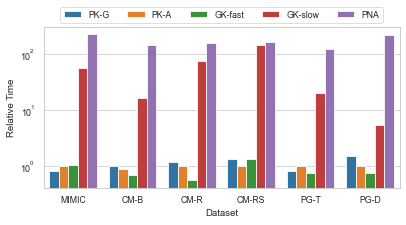

In [16]:
dataset_order = ["MIMIC", "CM-B", "CM-R", "CM-RS", "PG-T", "PG-D"]
selected_groups = ["PK-G", "PK-A", "GK-fast", "GK-slow", "PNA"]
plot = sns.barplot(x="Dataset", y="Relative Time", hue="Group", order=dataset_order, hue_order=selected_groups, data=rel_time_df)
plot.set_yscale("log")
plt.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.15))
plot.figure.set_size_inches(5.75, 3.25)
plt.tight_layout()

In [17]:
# saving the above plot
plot.figure.savefig("plots/best-performers-relative-timing.pdf")

### Figure 6: The mean classification accuracy of the best-performing provenance kernels, generic graph kernels, and PNA methods across the six classification tasks. The error bars show the 95-percent confidence intervals

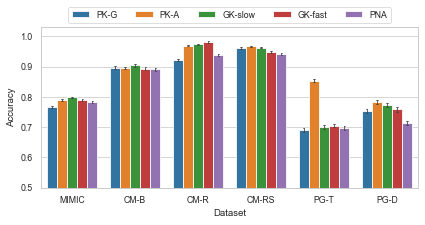

In [18]:
plt.figure()
selected_groups = ["PK-G", "PK-A", "GK-slow", "GK-fast", "PNA"]
df = scorings[scorings.group_name.isin(set(selected_groups))]
plot = sns.barplot(x="dataset", y="accuracy", hue="group_name",
                   hue_order=selected_groups, data=df, palette=current_palette,
                   errwidth=0.8, capsize=0.02)
plot.set(xlabel="Dataset", ylabel="Accuracy")
plot.figure.set_size_inches(6, 3.25)
plt.legend(loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.15))
plt.ylim(0.5)
plt.tight_layout()

In [19]:
plot.figure.savefig("plots/accuracy-best-performers.pdf")